In [1]:
# %%capture
# %run setup_PS_data_multi.ipynb
# print('------------------------------------')
# print(f'{len(sessions)} sessions are loaded')
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import pandas as pd
import time

path_to_vape = os.path.expanduser('~/Documents/code/Vape')
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))
import utils_funcs as utils

from Session import Session

/home/jrowland/Documents/code/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
popoff_path = os.path.expanduser('/home/jrowland/Documents/code/pop-off')
sessions_path = os.path.join(popoff_path, 'sessions.pkl')
                             
with open(sessions_path, 'rb') as f:
    sessions = pickle.load(f)


In [2]:
sessions_path = os.path.expanduser('~/mnt/qnap/session_pkls')

sessions_spks = {}
count = 0

for file in os.listdir(sessions_path):
    if 'spks' in file:# and count<6:
        with open(os.path.join(sessions_path, file), 'rb') as f:
            sessions_spks[count] = pickle.load(f)
        count+=1

In [4]:
sessions2 = {} 
count = 0
for idx, session in sessions.items():
    if repr(session) in repr(sessions_spks):
        
        sessions2[count] = session
        count+=1
sessions = sessions2

In [5]:
sessions

{0: instance Mouse RL070, run 28 of Session class,
 1: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J048, run 27 of Session class,
 3: instance Mouse J048, run 28 of Session class,
 4: instance Mouse J048, run 29 of Session class,
 5: instance Mouse J048, run 30 of Session class}

In [3]:
sessions_spks

{0: instance Mouse RL070, run 28 of Session class,
 1: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J048, run 27 of Session class,
 3: instance Mouse J048, run 28 of Session class,
 4: instance Mouse J048, run 29 of Session class,
 5: instance Mouse J048, run 30 of Session class,
 6: instance Mouse J048, run 32 of Session class,
 7: instance Mouse J064, run 10 of Session class,
 8: instance Mouse J064, run 11 of Session class,
 9: instance Mouse J064, run 14 of Session class,
 10: instance Mouse J063, run 8 of Session class,
 11: instance Mouse J063, run 9 of Session class,
 12: instance Mouse RL048, run 23 of Session class,
 13: instance Mouse RL048, run 24 of Session class,
 14: instance Mouse RL048, run 25 of Session class,
 15: instance Mouse RL048, run 28 of Session class,
 16: instance Mouse RL048, run 29 of Session class,
 17: instance Mouse J065, run 10 of Session class,
 18: instance Mouse J065, run 11 of Session class}

In [8]:
sessions = sessions_spks

In [9]:
#remove J065 run 14 because there is an alignment error
for idx, session in sessions.items():
    rep = repr(session)
    if 'J065' in rep and 'run 14' in rep:
        del_idx = idx
        break

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [12]:
session.__dict__.keys()

dict_keys(['mouse', 'run_number', 'signature', 'pkl_path', 'name', 'run', 'pre_seconds', 'post_seconds', 'pre_gap_seconds', 'post_gap_seconds', 'verbose', 'shuffled_s1s2_labels_indicator', 'shuffled_trial_labels_indicator', 'flu', 'tstart_galvo', 'trial_start', 'galvo_ms', 'subsets', 'trial_subsets', 'n_stim_arr', 'outcome', 'outcome_arr', 'deconved', 'denoised_flu', 'frequency', 'pre_frames', 'post_frames', 'art_gap_start', 'final_pre_gap_tp', 'art_gap_stop', 'filter_ps_array', 'filter_ps_time', 'behaviour_trials', 'pre_rew_trials', 'unfiltered_n_cells', 'filtered_neurons', 'n_cells', 'av_ypix', 'av_xpix', 'plane_number', 's2_bool', 's1_bool', 'decision', 'photostim', 'photostim_occ', 'autorewarded', 'unrewarded_hits', 'n_unique_stims', 'n_neurons', 'n_times', 'n_trials', 'n_unique_dec', 'occ_table', 'n_com_trials', 'nonnan_trials'])

In [13]:
## Integrate different imaging frequencies:
def get_tp_dict(sessions):
    freqs = np.unique([ss.frequency for _, ss in sessions.items()])
    tp_dict = {}
    for ff in freqs:
        for _, ss in sessions.items():   # assume pre_seconds & post_seconds equal for all sessions
            if ss.frequency == ff:
                tp_dict[ff] = ss.filter_ps_time
    if len(freqs) == 2:  # for hard-coded bit next up
        tp_dict['mutual'] = np.intersect1d(ar1=tp_dict[freqs[0]], ar2=tp_dict[freqs[1]])
    elif len(freqs) == 1:
        tp_dict['mutual'] = tp_dict[freqs[0]]
    
    return tp_dict

In [14]:
def get_frames_use(session, times_use):

    frames_use = []
    for tt in times_use:
        # this will throw an error if tt not in filter_ps_time
        frames = session.filter_ps_array[np.where(session.filter_ps_time == tt)[0][0]]
        frames_use.append(frames)
        
    assert len(times_use) == len(frames_use) 
    return np.array(frames_use)

In [15]:
baseline_start = -2
tp_dict = get_tp_dict(sessions)
times_use = tp_dict['mutual']
times_use = times_use[times_use >= baseline_start]

    
for idx, session in sessions.items():
    session.frames_use = get_frames_use(session, times_use)
    
for idx, session in sessions_spks.items():
    session.frames_use = get_frames_use(session, times_use)

In [16]:
def session_stacker(sessions, cells_include='s1', prereward=False):
   
    for idx, session in sessions.items():
        
        
        if cells_include == 's1':
            cell_bool = session.s1_bool[session.filtered_neurons]
        elif cells_include == 's2':
            cell_bool = session.s2_bool[session.filtered_neurons]
        
        if not prereward:
            behaviour_trials = session.behaviour_trials[cell_bool, :, :]
        else:
            behaviour_trials = session.pre_rew_trials[cell_bool, :, :]
        
        baseline_frames = np.where((session.filter_ps_time>=-2) & (session.filter_ps_time<0))[0]
        baseline = np.mean(behaviour_trials[:, :, baseline_frames], 2)
        
        baseline_subbed = behaviour_trials[:, :, session.frames_use] - baseline[:,:,np.newaxis]
        
        if idx == 0:
            stacked_trials = np.mean(baseline_subbed, 0)
        else:
            stacked_trials = np.vstack((stacked_trials, np.mean(baseline_subbed, 0)))
        
    return stacked_trials

In [17]:
def tt_idxs(session, trial_type='all', trial_outcome='all'):
    
    assert len(session.photostim) == len(session.decision)

    if trial_type == 'nogo':
        type_use = session.photostim == 0
    elif trial_type == 'test':
        type_use = session.photostim == 1
    elif trial_type == 'easy':
        type_use = session.photostim == 2
    elif trial_type == 'all':
        type_use = np.repeat(True, len(session.photostim))
        
    if trial_outcome == 'hit' or trial_outcome=='fp':
        outcome_use = np.logical_and(session.decision == 1, session.unrewarded_hits==False)
    elif trial_outcome == 'miss' or trial_outcome=='cr':
        outcome_use = np.logical_and(session.decision == 0, session.autorewarded==False)
    elif trial_outcome == 'ar_miss':
        outcome_use = session.autorewarded
    elif trial_outcome == 'ur_hit':
        outcome_use = session.unrewarded_hits
    elif trial_outcome == 'all':
        outcome_use = np.repeat(True, len(session.decision)) 
        
    return np.logical_and(type_use, outcome_use)

In [18]:
def tt_raveled(sessions, trial_type='all', trial_outcome='all'):
    
    trials_use = []
    
    for idx, session in sessions.items():
        trials_use.append(tt_idxs(session, trial_type, trial_outcome))
        
    return np.concatenate(trials_use)

In [19]:
def average_trace_plotter(df_plot, tt):
    
    color_tt = {'hit': 'green', 'miss': 'grey', 'fp': 'magenta', 'cr': 'brown', 
                'ur_hit': '#7b85d4', 'ar_miss': '#e9d043', 'spont_rew': 'darkorange'}

    sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=tt)
    sns.lineplot(data=df_plot[df_plot['timepoint'] >= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None)
        
    plt.ylim((-0.04,0.06))
    #plt.xlim((-2,4))
    plt.axhline(0)
        
    plt.xlabel('Time (s)')
    plt.ylabel(r"Spks")
    plt.legend(fontsize=10)

In [20]:
def plotting_df(stacked_trials, stacked_prereward=None):
    
    tts = ['hit', 'miss', 'ur_hit', 'ar_miss', 'spont_rew']
    #tts = ['hit', 'miss', 'ur_hit', 'ar_miss']
    #tts = ['hit', 'miss']
    
    for tt in tts:
        
        if tt=='spont_rew':
            assert stacked_prereward is not None
            diff_dff = stacked_prereward
        else:
            trials_use = tt_raveled(sessions, 'test', tt)
            diff_dff = stacked_trials[trials_use, :]
        
        d = {name: np.array([]) for name in ['diff_dff', 'timepoint']}  
        d['diff_dff'] = diff_dff.ravel()
        d['timepoint'] = np.tile(times_use, diff_dff.shape[0])

        df_plot = pd.DataFrame(d) 
        
        average_trace_plotter(df_plot, tt)
        plt.ylim(-0.005, 0.005)
    


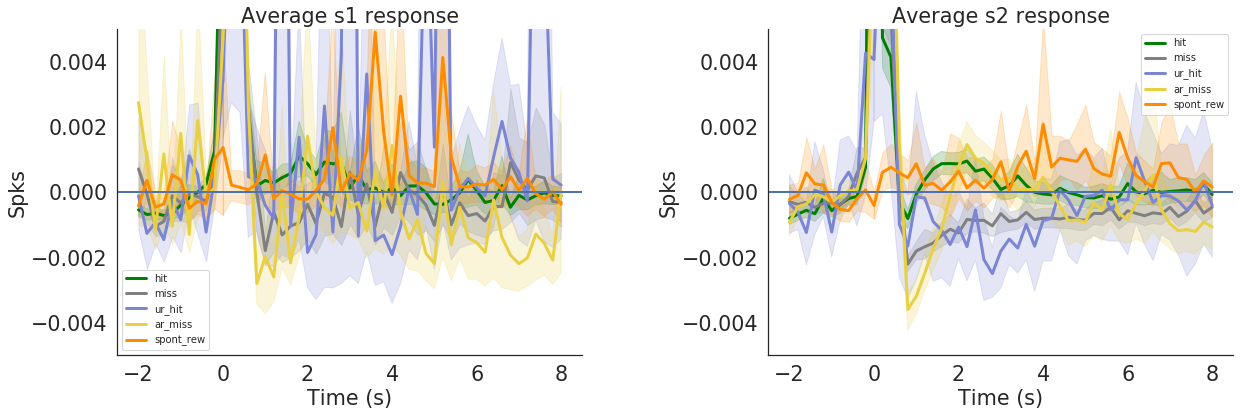

In [21]:
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.4,hspace=0.4)

for idx, region in enumerate(['s1', 's2']):
    plt.subplot(1,2,idx+1)
    behaviour = session_stacker(sessions, region, prereward=False)
    prereward = session_stacker(sessions, region, prereward=True)
    plotting_df(behaviour, prereward)
    
    plt.title('Average {} response'.format(region))
    

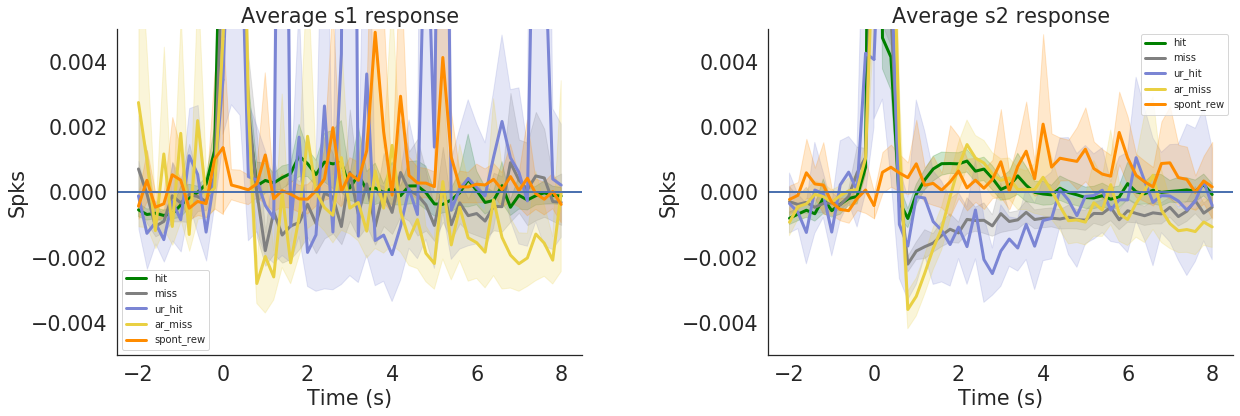

In [22]:
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.4,hspace=0.4)

for idx, region in enumerate(['s1', 's2']):
    plt.subplot(1,2,idx+1)
    behaviour = session_stacker(sessions_spks, region, prereward=False)
    prereward = session_stacker(sessions_spks, region, prereward=True)
    plotting_df(behaviour, prereward)
    
    plt.title('Average {} response'.format(region))
    

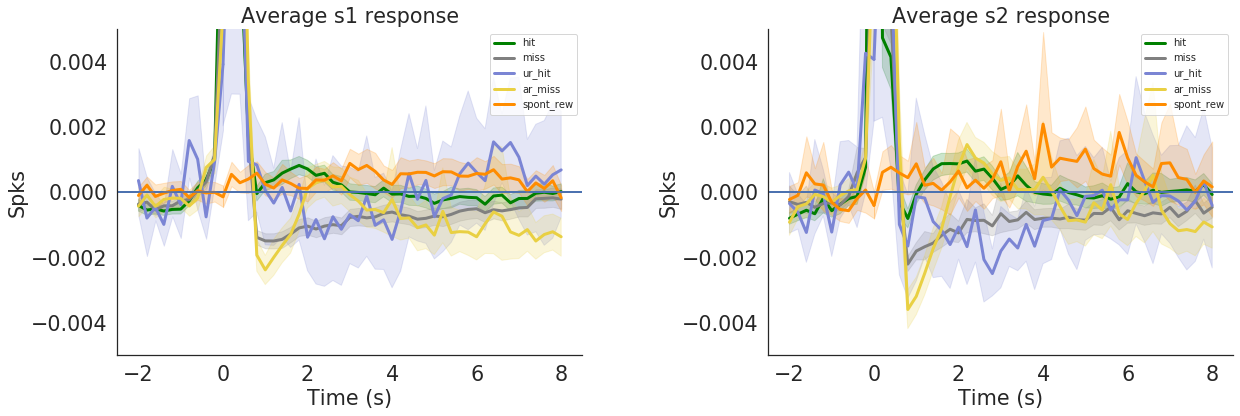

In [25]:
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.4,hspace=0.4)

for idx, region in enumerate(['s1', 's2']):
    plt.subplot(1,2,idx+1)
    behaviour = session_stacker(sessions_spks, region, prereward=False)
    prereward = session_stacker(sessions_spks, region, prereward=True)
    plotting_df(behaviour, prereward)
    
    plt.title('Average {} response'.format(region))
    

In [24]:

for idx, session_spks in sessions_spks.items():
    
    session_spks.filter_neurons(abs_threshold=1)

1 / 625 cells filtered
0 / 718 cells filtered
0 / 2101 cells filtered
0 / 2194 cells filtered
0 / 1531 cells filtered
0 / 2085 cells filtered
0 / 1972 cells filtered
0 / 477 cells filtered
0 / 802 cells filtered
0 / 981 cells filtered
0 / 160 cells filtered
0 / 760 cells filtered
0 / 3571 cells filtered
0 / 3063 cells filtered
0 / 2892 cells filtered
0 / 2727 cells filtered
0 / 1992 cells filtered
0 / 131 cells filtered
0 / 410 cells filtered


In [210]:
session_idx = np.random.randint(0, len(sessions))
trial_idx = np.random.randint(0, 100)
cell_idx = np.random.randint(0, 500)


assert(sessions[session_idx].behaviour_trials.shape == sessions_spks[session_idx].behaviour_trials.shape)

arr1 = sessions[session_idx].behaviour_trials[cell_idx, trial_idx,:]
arr2 = sessions_spks[session_idx].behaviour_trials[cell_idx, trial_idx,:]

#arr1 = np.mean(sessions[session_idx].behaviour_trials[cell_idx, :, :], 0)
#arr2 = np.mean(sessions_spks[session_idx].behaviour_trials[cell_idx, :, :], 0)

fig, ax1 = plt.subplots()
ax1.plot(arr1)

ax2 = ax1.twinx()
ax2.plot(arr2, color='red')

AssertionError: 

In [ ]:

sessions[session_idx].behaviour_trials.shape

In [ ]:
sessions_spks[session_idx].behaviour_trials.shape

In [ ]:
arr2.shape

In [ ]:
def get_trial_frames_single(clock, start, pre_frames, post_frames, fs=30, paq_rate=20000):
    """Get frames that indicate trial start.

    Parameters:
    ----------------
        clock: ??
            ??
        start: ??
            ??
        pre_frames: int
            number of frames before stim to include in trial
        post_frames: int
            number of frames after stim to include in trial
        fs: int, default=30
            frame rate of imaging
        paq_rate: int, default=20000
            ??

    Returns:
    ---------------
        trial_frames: ??
            ??
    """
    # the frames immediately preceeding stim
    frame_idx = utils.closest_frame_before(clock, start)
    trial_frames = np.arange(frame_idx-pre_frames, frame_idx+post_frames)

    # is the trial outside of the frame clock
    is_beyond_clock = np.max(trial_frames) >= len(clock) or np.min(trial_frames) < 0

    if is_beyond_clock:
        return None

    frame_to_start = (start - clock[frame_idx]) / paq_rate  # time (s) from frame to trial_start
    frame_time_diff = np.diff(clock[trial_frames]) / paq_rate  # ifi (s)

    # did the function find the correct frame
    is_not_correct_frame = clock[frame_idx+1]  < start or clock[frame_idx] > start
    # the nearest frame to trial start was not during trial
    trial_not_running = frame_to_start > 1/fs
    #
    frames_not_consecutive = np.max(frame_time_diff) > 1/(fs-1)

    if trial_not_running or frames_not_consecutive:
        return None
    return trial_frames

In [ ]:
session = sessions[0]
session

In [ ]:
session_spks = sessions_spks[0]
session_spks

In [ ]:
def build_flu_array_single(run, prereward=False, pre_frames=30, post_frames=80, fs=30):
    ''' Build an trial by trial fluoresence array of shape [n_cells x n_frames x n_trials].

    Parameters:
    ---------------
        run: run object
            run object containing data
        pre_frames: int, default=30
            number of frames before stim to include in trial
        post_frames: int, default=80
            number of frames after stim to include in trial
        fs: int, default=30
            frame rate of imaging

    Returns:
    ---------------
        flu_array: 3D np.array
            matrix of fluorescence data
    '''

    flu = run.flu
    # the frames that were actually imaged and the time (samples) that they occured
    clock = run.paqio_frames

    if prereward:
        # Time of prereward trial starts in paq samples
        trial_start = run.prereward_aligner.A_to_B(run.pre_reward)
    else:
        # Times of main behaviour trial start in paq samples
        trial_start = run.spiral_start
        # check that the number of trial starts detected by x galvo thresholding
        # matches the number of trials reported by pycontrol
        assert len(trial_start) == len(run.trial_start)

    for i, start in enumerate(trial_start):

        trial_frames = get_trial_frames_single(clock, start, pre_frames, post_frames)

        if trial_frames is None:
            flu_trial = np.full([flu.shape[0], pre_frames+post_frames], np.nan)
        else:
            flu_trial = flu[:, trial_frames]

        if i == 0:
            flu_array = flu_trial
        else:

            flu_array = np.dstack((flu_array, flu_trial))


    return np.swapaxes(flu_array,2,1)

In [ ]:
def build_trials_multi(session, vverbose=1):
    """Construct 3D matrix of neural data (n_cells x n_trials x n_frames) for multi-plane data sets."""
    # array of fluoresence through behavioural trials (n_cells x n_trials x n_frames)
    # with e.g. the first trials spanning (galvo_ms[0] - pre_frames) : (galvo_ms[0] + post_frames)
    session.behaviour_trials = utils.build_flu_array(session.run, session.galvo_ms,
                                                  pre_frames=session.pre_frames, post_frames=session.post_frames)
#         session.behaviour_trials = session.behaviour_trials - np.nanmean(session.behaviour_trials, (1, 2))[:, np.newaxis, np.newaxis]
    if vverbose >= 2:
        print(f'Shape new array : :%s/{session.behaviour_trials.shape}')
    assert session.behaviour_trials.shape[1] == session.outcome.shape[0]

    session.pre_rew_trials = utils.build_flu_array(session.run, session.run.pre_reward, session.post_frames,
                                                 session.pre_frames, is_prereward=True) 

    nan_trials = np.any(np.isnan(session.pre_rew_trials), axis=(0,2))
    session.pre_rew_trials = session.pre_rew_trials[:, ~nan_trials, :]

    assert np.sum(np.isnan(session.pre_rew_trials)) == 0

    if vverbose >= 2:
        print(session.behaviour_trials.shape, session.pre_rew_trials.shape)

def build_trials_single(session, vverbose=1):
    """Construct 3D matrix of neural data (n_cells x n_trials x n_frames) for single-plane data sets."""
    # array of fluoresence through behavioural trials (n_cells x n_trials x n_frames)
    # with e.g. the first trials spanning (galvo_ms[0] - pre_frames) : (galvo_ms[0] + post_frames)
    behaviour_trials = build_flu_array_single(session.run, prereward=False,
                                                   pre_frames=session.pre_frames,
                                                   post_frames=session.post_frames, fs=30)
    behaviour_trials = behaviour_trials[:, session.nonnan_trials, :]

    if vverbose >= 2:
        print(f'Shape new array : {session.behaviour_trials.shape}')
    assert behaviour_trials.shape[1] == session.outcome.shape[0],\
           '{} {}'.format(behaviour_trials.shape[1], session.outcome.shape[0])

    pre_rew_trials = build_flu_array_single(session.run, prereward=True,
                                                 pre_frames=session.pre_frames,
                                                 post_frames=session.post_frames, fs=30)
    
    return session.behaviour_trials

In [ ]:
sessions_spks[0]

In [ ]:
arr = build_trials_single(sessions_spks[0])

In [ ]:
assert (arr == sessions_spks[0].behaviour_trials).all()

In [ ]:
plt.imshow(session.run.flu)

In [ ]:
plt.hist()

In [ ]:
plt.hist(np.mean(sessions_spks[1].run.flu, 1))

plt.ylim((0,10))

In [ ]:
fig,ax1 = plt.subplots()
ax1.plot(np.sort(sessions_spks[0].flu, axis=0)[-1,:])
ax2 = ax1.twinx()
ax2.plot(np.sort(sessions_spks[0].deconved, axis=0)[-1,:])


In [ ]:
sort_boi = np.sort(sessions_spks[0].run.flu, axis=0)

In [ ]:
sort_boi.shape


In [ ]:
sessions_spks[0].flu.shape

In [ ]:

sessions_spks[0].deconved.shape

In [ ]:
np.argsort(np.mean(session_spks.deconved, 0), axis=1).shape

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(session_spks.deconved[535, :])


ax2 = ax1.twinx()

ax2.plot(session_spks.flu[535, :], color='red')

plt.xlim(500,1000)

In [ ]:
np.argsort(np.mean(session_spks.deconved, 1))

In [ ]:
np.max(session_spks.deconved[535, :])

In [ ]:
session_spks.__dict__.keys()

In [ ]:
plt.hist(np.mean(session_spks.deconved, 1))
plt.ylim(0,10)

In [211]:

session_spks = sessions_spks[0]
session_spks.behaviour_trials.shape

(625, 373, 360)

In [212]:
session_spks.filter_neurons(abs_threshold=1)

1 / 625 cells filtered


In [213]:
session_spks.s1_bool.shape

(625,)

In [214]:
session_spks.run.flu.shape


(624, 145715)

In [215]:
session_spks.behaviour_trials.shape

(624, 373, 360)

In [216]:
session_spks.filtered_neurons.shape

(624,)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
session_spks.behaviour_trials.shape